# several ML regression methods test and hyperparameters tuning procedure

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

True


365

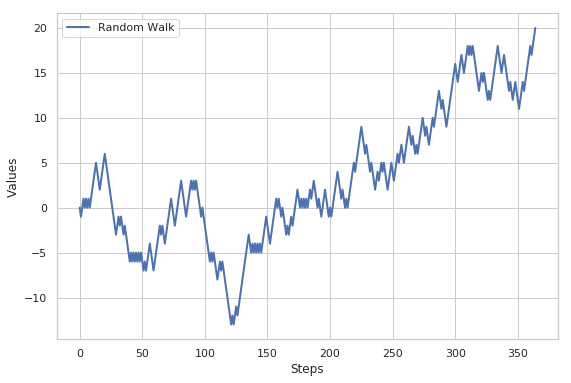

In [2]:
# 生成随机漫步序列

position = 0
walk = [position]
steps = 364
for i in range(steps):
    if random.randint(0,1) == 1:
        step = 1
    else: step = -1
    position = position + step
    walk.append(position)
x = list(range(steps+1))
plt.figure(figsize=(8,6))
plt.plot(x,walk[:steps+1],linewidth=2,label='Random Walk')
plt.xlabel('Steps')
plt.ylabel('Values')
plt.legend()
print(len(walk) == len(x))
len(walk)

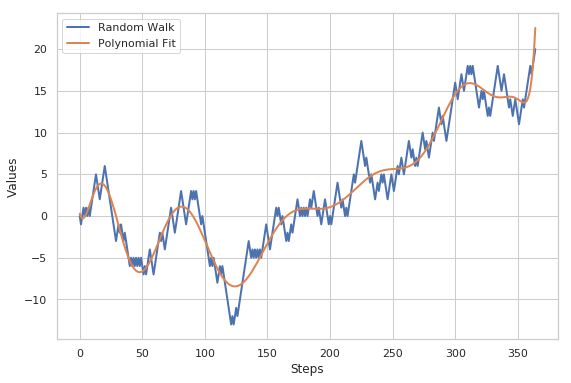

In [3]:
# 使用高次多项式拟合随机漫步序列

coe_poly = np.polyfit(x,walk,15) # polyfit方法拟合x与walk，生成多项式系数。
func_poly = np.poly1d(coe_poly)  # poly1d方法使用系数生成多项式函数。
value_poly = func_poly(x)
plt.figure(figsize=(8,6))
plt.plot(x,walk,linewidth=2,label='Random Walk')
plt.plot(x,value_poly,linewidth=2,label='Polynomial Fit')
plt.xlabel('Steps')
plt.ylabel('Values')
plt.legend()

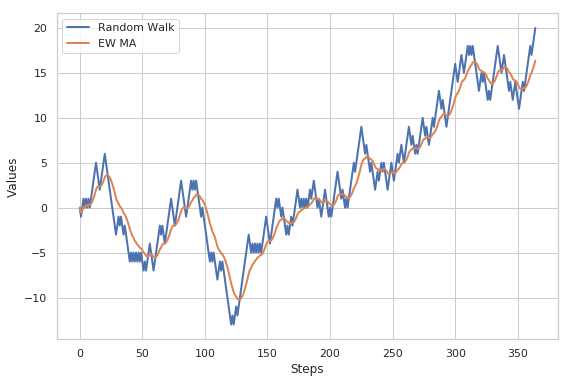

In [4]:
# 使用指数加权移动平均拟合随机漫步序列

walk = pd.Series(walk)
ewma = walk.ewm(span=15).mean()
plt.figure(figsize=(8,6))
plt.plot(x,walk,linewidth=2,label='Random Walk')
plt.plot(x,ewma,linewidth=2,label='EW MA')
plt.xlabel('Steps')
plt.ylabel('Values')
plt.legend()

In [5]:
# 读取训练集和验证集
train = pd.read_csv('train.csv')
train_df = train.copy()
print(train_df.info())
train_df.describe()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 9 columns):
code          6006 non-null int64
class         6006 non-null int64
busdate       6006 non-null object
weekday       6006 non-null int64
week          6006 non-null int64
festival      6006 non-null int64
fix_amount    6006 non-null float64
price         6006 non-null float64
sum_price     6006 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 422.4+ KB
None


,code,class,busdate,weekday,week,festival,fix_amount,price,sum_price
0,6921168509256,10,2015-12-20,6,51,0,2.0,1.8,3.6
1,6921168509256,10,2015-12-21,0,52,0,3.0,1.8,5.4
2,6921168509256,10,2015-12-22,1,52,0,2.0,1.8,3.6
3,6921168509256,10,2015-12-23,2,52,0,2.0,1.8,3.6
4,6921168509256,10,2015-12-24,3,52,0,1.0,1.8,1.8


In [6]:
# 读取测试集
test = pd.read_csv('test.csv')
test_df = test.copy()
print(test_df.info())
test_df.describe()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 9 columns):
code          1086 non-null int64
class         1086 non-null int64
busdate       1086 non-null object
weekday       1086 non-null int64
week          1086 non-null int64
festival      1086 non-null int64
fix_amount    1086 non-null float64
price         1086 non-null float64
sum_price     1086 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 76.4+ KB
None


,code,class,busdate,weekday,week,festival,fix_amount,price,sum_price
0,6921168509256,10,2018-09-16,6,37,7,12.0,1.5,18.0
1,6921168509256,10,2018-09-17,0,38,7,7.0,1.5,10.5
2,6921168509256,10,2018-09-18,1,38,7,5.0,1.5,7.5
3,6921168509256,10,2018-09-19,2,38,7,15.0,1.5,22.5
4,6921168509256,10,2018-09-20,3,38,7,12.0,1.5,18.0


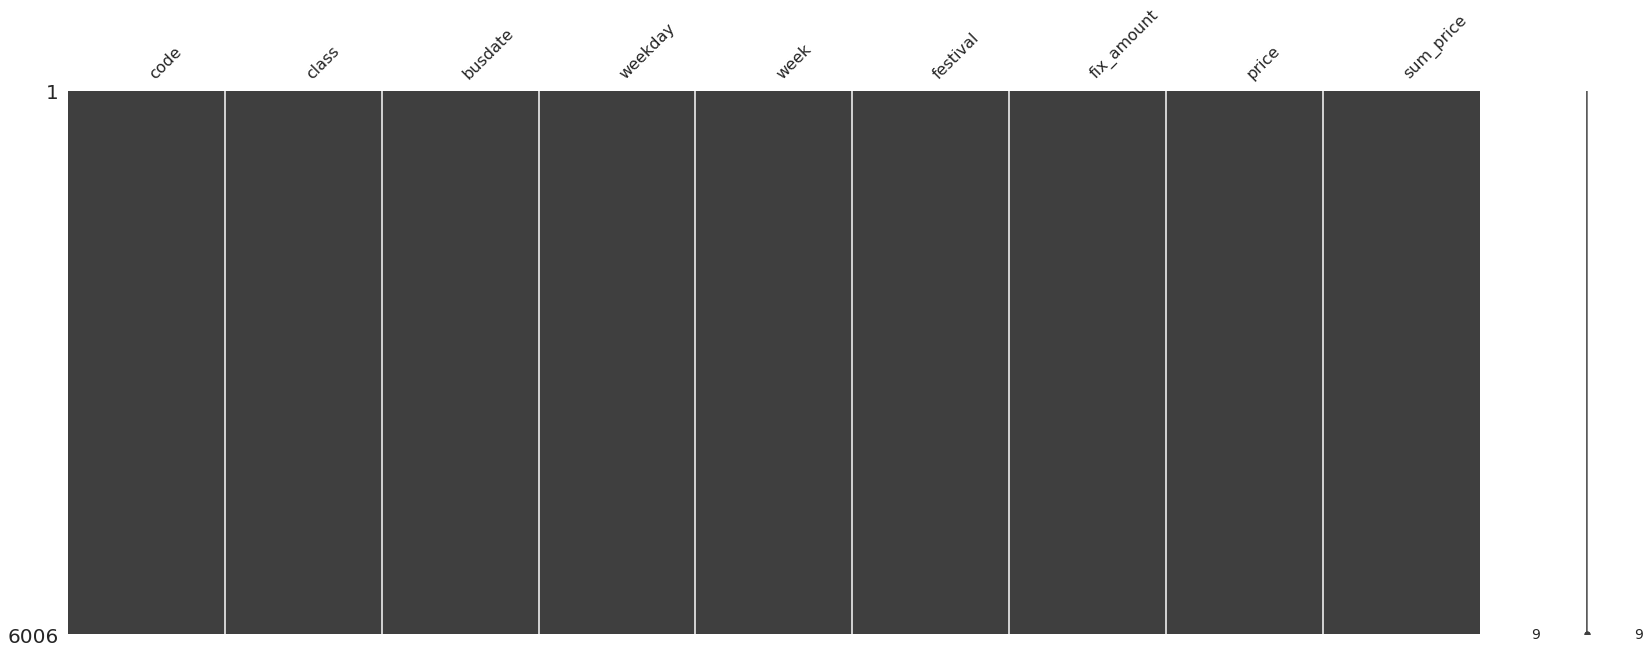

In [7]:
# 查看traimn_df中是否有null值
msno.matrix(train_df)

0    4110
2     702
5     306
7     222
6     180
3     126
1     126
9      84
4      84
8      66
Name: festival, dtype: int64

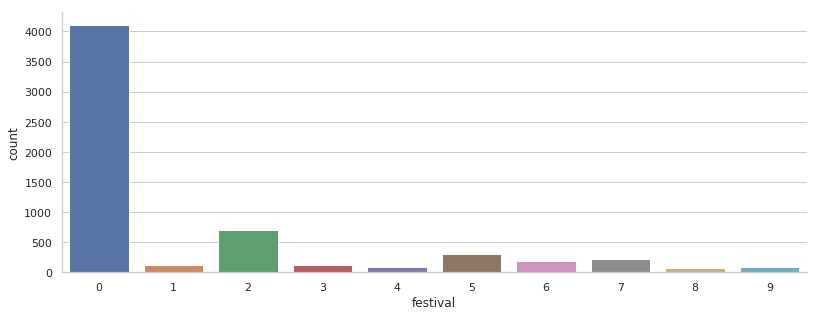

In [8]:
# 查看festival的分布律
sns.catplot(x='festival',data=train_df,kind='count',height=4.5,aspect=2.5)
train_df.festival.value_counts()

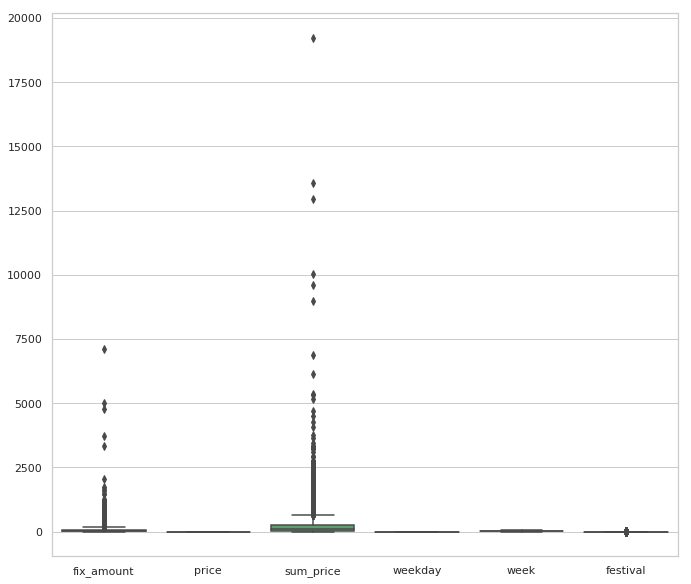

In [9]:
# 查看各变量按各单品汇总后的箱线图
sns.boxplot(data=train_df[['fix_amount', 'price', 'sum_price','weekday','week','festival']])
fig=plt.gcf()
fig.set_size_inches(10,10)

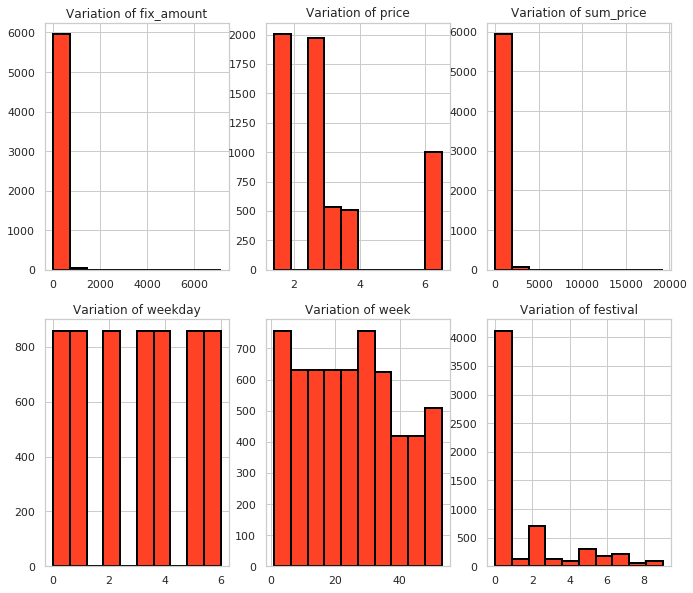

In [10]:
# 查看各变量按单品汇总后的分布律

fig,axes=plt.subplots(2,3)
axes[0,0].hist(x="fix_amount",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of fix_amount")
axes[0,1].hist(x="price",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of price")
axes[0,2].hist(x="sum_price",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,2].set_title("Variation of sum_price")
axes[1,0].hist(x="weekday",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of weekday")
axes[1,1].hist(x="week",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of week")
axes[1,2].hist(x="festival",data=train_df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,2].set_title("Variation of festival")
fig.set_size_inches(10,10)

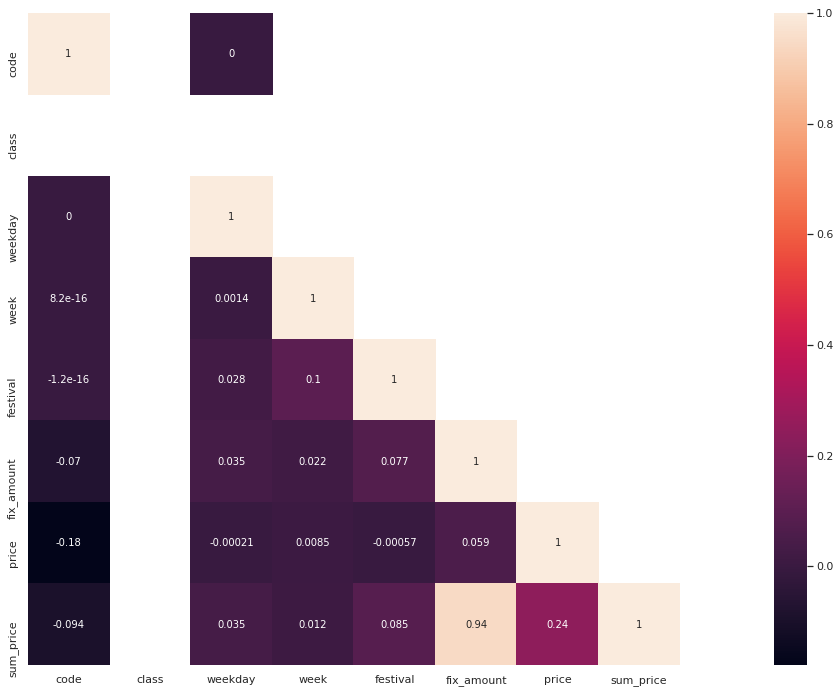

In [11]:
# 查看原始数据各变量的相关系数矩阵
cor_mat = train_df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [12]:
# 开始对原始数据进行数值变换，使其与算法更适合，以提升预测精度。

In [13]:
# 减少festival变量的取值数目，使算法更容易计算其与目标变量的对应关系。
train_df['festival_fix'] = train_df.festival.replace([3,4,5,6,7,8,9],[1,1,1,1,1,1,1])
train_df.describe()
train_df

,code,class,busdate,weekday,week,festival,fix_amount,price,sum_price,festival_fix
0,6921168509256,10,2015-12-20,6,51,0,2.0,1.8,3.6,0
1,6921168509256,10,2015-12-21,0,52,0,3.0,1.8,5.4,0
2,6921168509256,10,2015-12-22,1,52,0,2.0,1.8,3.6,0
3,6921168509256,10,2015-12-23,2,52,0,2.0,1.8,3.6,0
4,6921168509256,10,2015-12-24,3,52,0,1.0,1.8,1.8,0
5,6921168509256,10,2015-12-25,4,52,0,0.0,1.8,0.0,0
6,6921168509256,10,2015-12-26,5,52,0,2.0,1.8,3.6,0
7,6921168509256,10,2015-12-27,6,52,0,3.0,1.8,5.4,0
8,6921168509256,10,2015-12-28,0,53,0,0.0,1.8,0.0,0
9,6921168509256,10,2015-12-29,1,53,1,1.0,1.8,1.8,1


In [14]:
# 对测试集要进行相同操作，保证一致的输入数据结构。
test_df['festival_fix'] = test_df.festival.replace([3,4,5,6,7,8,9],[1,1,1,1,1,1,1])
test_df.describe()

,code,class,weekday,week,festival,fix_amount,price,sum_price,festival_fix
count,1.086000e+03,1086.0,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,6.911679e+12,10.0,2.988950,28.740331,1.740331,70.565378,3.127624,277.907195,0.635359
std,7.982875e+09,0.0,2.000891,19.639159,2.781236,98.946100,1.681505,521.461286,0.814388
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,0.000000,1.500000,0.000000,0.000000
25%,6.907992e+12,10.0,1.000000,7.000000,0.000000,11.000000,1.500000,18.000000,0.000000
50%,6.907993e+12,10.0,3.000000,40.000000,0.000000,36.000000,2.800000,101.500000,0.000000
75%,6.921169e+12,10.0,5.000000,46.000000,2.000000,98.000000,3.500000,381.000000,1.000000
max,6.923644e+12,10.0,6.000000,52.000000,9.000000,1684.000000,6.500000,10946.000000,2.000000


In [15]:
# 将festival_fix变量转化为虚拟变量，使其更适用于算法。
festival = pd.get_dummies(train_df['festival_fix'],prefix='festival_fix')
train_df1 = pd.concat([train_df,festival],axis=1)
train_df2 = train_df1.drop(['festival','festival_fix'],inplace=False,axis=1)
train_df2.head()

,code,class,busdate,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2
0,6921168509256,10,2015-12-20,6,51,2.0,1.8,3.6,1,0,0
1,6921168509256,10,2015-12-21,0,52,3.0,1.8,5.4,1,0,0
2,6921168509256,10,2015-12-22,1,52,2.0,1.8,3.6,1,0,0
3,6921168509256,10,2015-12-23,2,52,2.0,1.8,3.6,1,0,0
4,6921168509256,10,2015-12-24,3,52,1.0,1.8,1.8,1,0,0


In [16]:
festival = pd.get_dummies(test_df['festival_fix'],prefix='festival_fix')
test_df1 = pd.concat([test_df,festival],axis=1)
test_df2 = test_df1.drop(['festival','festival_fix'],inplace=False,axis=1)
test_df2.describe()

,code,class,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2
count,1.086000e+03,1086.0,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,6.911679e+12,10.0,2.988950,28.740331,70.565378,3.127624,277.907195,0.580110,0.204420,0.215470
std,7.982875e+09,0.0,2.000891,19.639159,98.946100,1.681505,521.461286,0.493768,0.403463,0.411337
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000
25%,6.907992e+12,10.0,1.000000,7.000000,11.000000,1.500000,18.000000,0.000000,0.000000,0.000000
50%,6.907993e+12,10.0,3.000000,40.000000,36.000000,2.800000,101.500000,1.000000,0.000000,0.000000
75%,6.921169e+12,10.0,5.000000,46.000000,98.000000,3.500000,381.000000,1.000000,0.000000,0.000000
max,6.923644e+12,10.0,6.000000,52.000000,1684.000000,6.500000,10946.000000,1.000000,1.000000,1.000000


In [17]:
# 从时间戳中提取年、月、日信息
train_df2["dayofweek"] = [t.dayofweek for t in pd.DatetimeIndex(train_df2.busdate)]
train_df2["month"] = [t.month for t in pd.DatetimeIndex(train_df2.busdate)]
train_df2['year'] = [t.year for t in pd.DatetimeIndex(train_df2.busdate)]
train_df2['year'] = train_df2['year'].map({2015:0, 2016:1, 2017:2, 2018:3})
train_df2['season'] = np.floor(train_df2['week']//14)
train_df2.describe()

,code,class,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,month,year,season
count,6.006000e+03,6006.0,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000,6006.000000
mean,6.911679e+12,10.0,3.000000,24.937063,76.884282,3.026427,250.895847,0.684316,0.198801,0.116883,3.000000,6.138861,1.868132,1.329670
std,7.979864e+09,0.0,2.000167,14.676836,188.232395,1.645399,575.565810,0.464827,0.399131,0.321308,2.000167,3.352958,0.808733,1.050851
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,6.907992e+12,10.0,1.000000,12.000000,16.000000,1.500000,28.500000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000
50%,6.907993e+12,10.0,3.000000,24.000000,38.000000,2.800000,94.500000,1.000000,0.000000,0.000000,3.000000,6.000000,2.000000,1.000000
75%,6.921169e+12,10.0,5.000000,36.000000,78.000000,3.500000,275.600000,1.000000,0.000000,0.000000,5.000000,9.000000,3.000000,2.000000
max,6.923644e+12,10.0,6.000000,53.000000,7126.000000,6.500000,19240.200000,1.000000,1.000000,1.000000,6.000000,12.000000,3.000000,3.000000


In [18]:
test_df2["dayofweek"] = [t.dayofweek for t in pd.DatetimeIndex(test_df2.busdate)]
test_df2["month"] = [t.month for t in pd.DatetimeIndex(test_df2.busdate)]
test_df2['year'] = [t.year for t in pd.DatetimeIndex(test_df2.busdate)]
test_df2['year'] = test_df2['year'].map({2018:3, 2019:4})
test_df2['season'] = np.floor(test_df2['week']//14)
test_df2.describe()

,code,class,weekday,week,fix_amount,price,sum_price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,month,year,season
count,1.086000e+03,1086.0,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,6.911679e+12,10.0,2.988950,28.740331,70.565378,3.127624,277.907195,0.580110,0.204420,0.215470,2.988950,7.066298,3.408840,1.596685
std,7.982875e+09,0.0,2.000891,19.639159,98.946100,1.681505,521.461286,0.493768,0.403463,0.411337,2.000891,4.492208,0.491846,1.386355
min,6.901286e+12,10.0,0.000000,1.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,6.907992e+12,10.0,1.000000,7.000000,11.000000,1.500000,18.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,6.907993e+12,10.0,3.000000,40.000000,36.000000,2.800000,101.500000,1.000000,0.000000,0.000000,3.000000,10.000000,3.000000,2.000000
75%,6.921169e+12,10.0,5.000000,46.000000,98.000000,3.500000,381.000000,1.000000,0.000000,0.000000,5.000000,11.000000,4.000000,3.000000
max,6.923644e+12,10.0,6.000000,52.000000,1684.000000,6.500000,10946.000000,1.000000,1.000000,1.000000,6.000000,12.000000,4.000000,3.000000


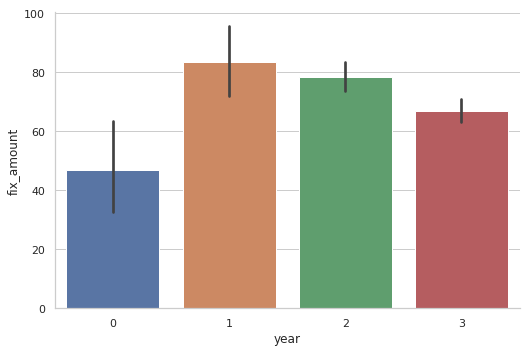

In [19]:
# 查看训练集中各单品汇总的年销量
sns.catplot(x="year",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

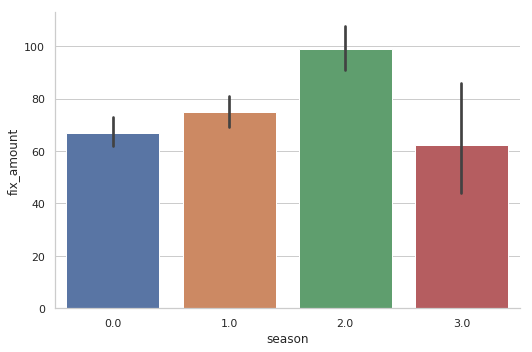

In [20]:
# 查看训练集中各单品汇总的季度销量
sns.catplot(x="season",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

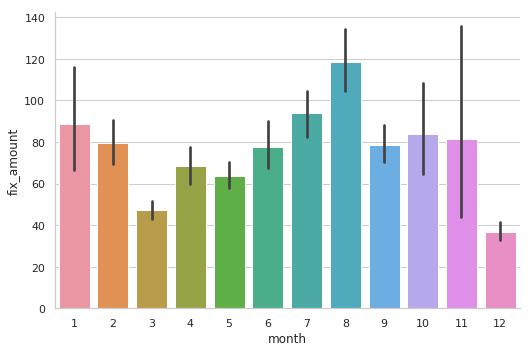

In [21]:
# 查看训练集中各单品汇总的月销量
sns.catplot(x="month",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

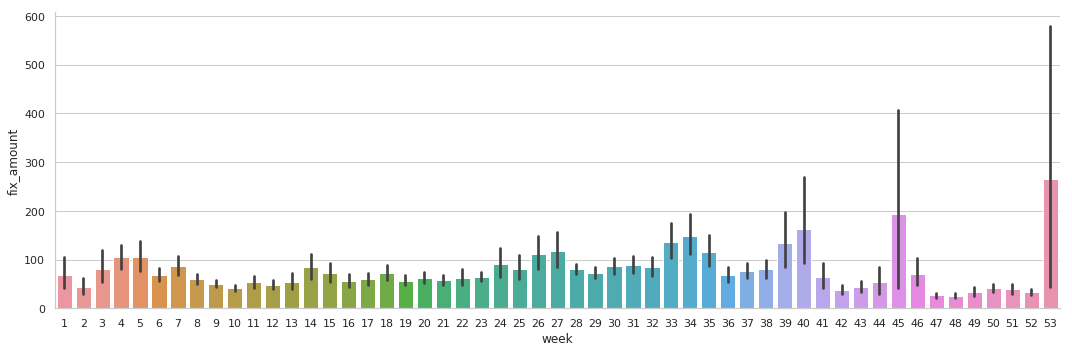

In [22]:
# 查看训练集中各单品汇总的周销量
sns.catplot(x="week",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=3)

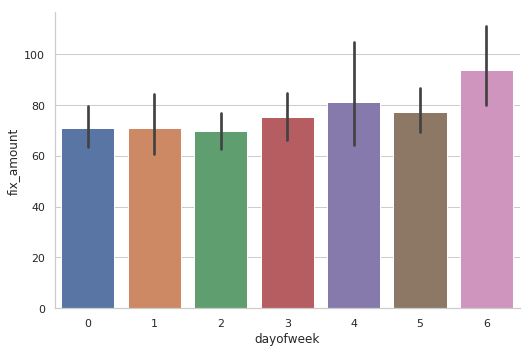

In [23]:
# 查看训练集中各单品汇总的星期销量
sns.catplot(x="dayofweek",y="fix_amount",data=train_df2,kind='bar',height=5,aspect=1.5)

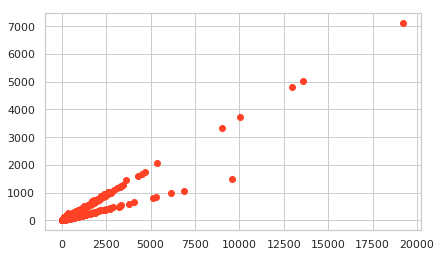

In [24]:
# 查看sum_price与fix_amount间的关系
plt.scatter(x="sum_price",y="fix_amount",data=train_df2,color='#ff4125')

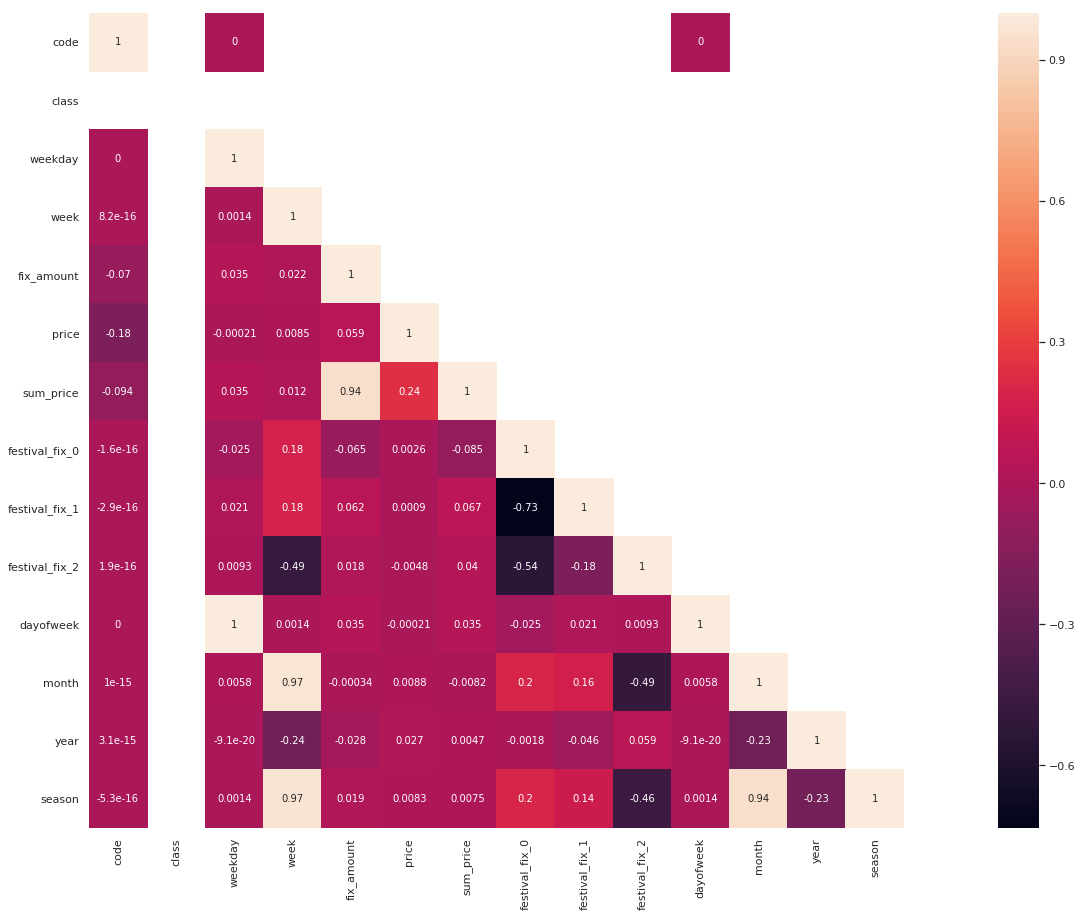

In [25]:
# 查看各变量间的相关性
cor_mat= train_df2[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [26]:
# 根据上一步的相关系数矩阵，确定需要输入的相关变量。
train_df3 = train_df2.drop(['busdate','code','class','weekday','fix_amount',
                            'sum_price','week','month'],axis=1,inplace=False)
test_df3 = test_df2.drop(['busdate','code','class','weekday','fix_amount',
                          'sum_price','week','month'],axis=1,inplace=False)
print(len(train_df3.columns)==len(test_df3.columns))

True


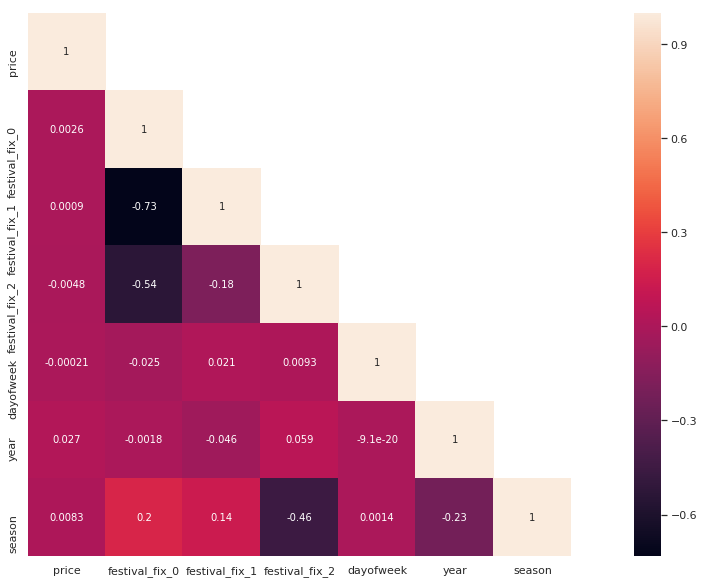

In [27]:
# 再次确认各变量相关系数
cor_mat= train_df3[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,10)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [28]:
# 查看每种数据类型的成员
train_df3.columns.to_series().groupby(train_df3.dtypes).groups

{dtype('uint8'): Index(['festival_fix_0', 'festival_fix_1', 'festival_fix_2'], dtype='object'),
 dtype('int64'): Index(['dayofweek', 'year'], dtype='object'),
 dtype('float64'): Index(['price', 'season'], dtype='object')}

In [29]:
train_df3.describe()
train_df3.head(10)

,price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,year,season
0,1.8,1,0,0,6,0,3.0
1,1.8,1,0,0,0,0,3.0
2,1.8,1,0,0,1,0,3.0
3,1.8,1,0,0,2,0,3.0
4,1.8,1,0,0,3,0,3.0
5,1.8,1,0,0,4,0,3.0
6,1.8,1,0,0,5,0,3.0
7,1.8,1,0,0,6,0,3.0
8,1.8,1,0,0,0,0,3.0
9,1.8,0,1,0,1,0,3.0


In [30]:
test_df3.describe()

,price,festival_fix_0,festival_fix_1,festival_fix_2,dayofweek,year,season
count,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000
mean,3.127624,0.580110,0.204420,0.215470,2.988950,3.408840,1.596685
std,1.681505,0.493768,0.403463,0.411337,2.000891,0.491846,1.386355
min,1.500000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,1.500000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
50%,2.800000,1.000000,0.000000,0.000000,3.000000,3.000000,2.000000
75%,3.500000,1.000000,0.000000,0.000000,5.000000,4.000000,3.000000
max,6.500000,1.000000,1.000000,1.000000,6.000000,4.000000,3.000000


In [31]:
# 将相关变量和目标变量拆分成训练集和验证集
x_train,x_validate,y_train,y_validate = train_test_split(train_df3,train_df2['fix_amount'],
                                                 test_size=1/6,random_state=43,shuffle=False)
y_validate

5005     96.0
5006     98.0
5007     96.0
5008    109.0
5009    132.0
5010     97.0
5011     60.0
5012    122.0
5013    120.0
5014     36.0
5015     75.0
5016    193.0
5017     24.0
5018     12.0
5019     14.0
5020     13.0
5021     24.0
5022     48.0
5023     25.0
5024     84.0
5025     48.0
5026     85.0
5027     48.0
5028     24.0
5029     24.0
5030     72.0
5031     64.0
5032     28.0
5033     48.0
5034     12.0
        ...  
5976     86.0
5977    109.0
5978     72.0
5979     97.0
5980     14.0
5981    109.0
5982    120.0
5983    132.0
5984    108.0
5985    158.0
5986    146.0
5987     84.0
5988    196.0
5989    168.0
5990    182.0
5991    111.0
5992    159.0
5993    134.0
5994    146.0
5995     84.0
5996     72.0
5997    109.0
5998     99.0
5999    156.0
6000    111.0
6001     48.0
6002     61.0
6003     61.0
6004     96.0
6005     87.0
Name: fix_amount, Length: 1001, dtype: float64

In [32]:
# 使用训练集训练多种模型，用验证集比较RMSE，初步确定较优模型。

models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),GradientBoostingRegressor(),
        SVR(),KNeighborsRegressor(),LinearRegression(),Ridge(),Lasso(),RidgeCV()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','GradientBoostingRegressor',
             'SVR','KNeighborsRegressor','LinearRegression','Ridge','Lasso','RidgeCV']
rmse=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_validate)
    rmse.append(np.sqrt(mean_squared_error(test_pred,y_validate)))
d={'Modelling Algo':model_names,'RMSE':rmse}
rmse_frame=pd.DataFrame(d)
rmse_frame

,Modelling Algo,RMSE
0,RandomForestRegressor,104.658678
1,AdaBoostRegressor,103.345251
2,BaggingRegressor,105.587123
3,GradientBoostingRegressor,108.060110
4,SVR,115.326566
5,KNeighborsRegressor,105.035829
6,LinearRegression,185.878760
7,Ridge,185.923416
8,Lasso,179.318175
9,RidgeCV,185.473122


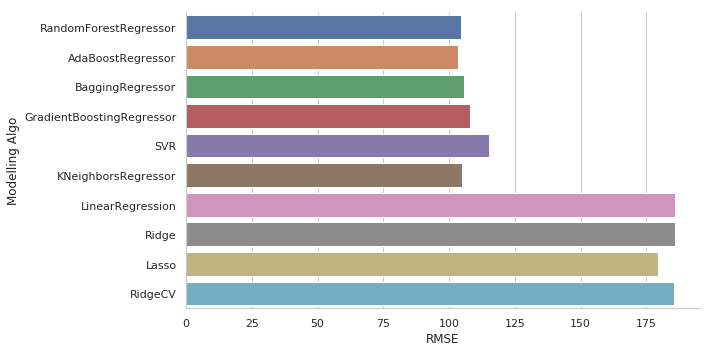

In [33]:
# 查看各算法的RMSE
sns.catplot(y='Modelling Algo',x='RMSE',data=rmse_frame,kind='bar',height=5,aspect=2)

In [34]:
# 对SVR进行超参数优化，并得出最终预测结果。

In [35]:
# 再次使用训练集训练SVR，并用验证集观察RMSE，确定超参数。

params_dict = {"C":list(range(1,31,10))}
clf_svr = GridSearchCV(estimator=SVR(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_svr.fit(x_train,y_train)
pred = clf_svr.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_svr.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


158.837738779649


{'C': 21}

In [36]:
# 最后用训练集加验证集再次训练SVR，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'C':[clf_svr.best_params_['C']]}
clf_svr = GridSearchCV(estimator=SVR(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_svr.fit(train_df3, train_df2['fix_amount'])
pred = clf_svr.predict(test_df3)
d = {'datetime':test_df2['busdate'],'pred_svr':pred}
pred_svr = pd.DataFrame(d)
print(pred_svr.head())
print(pred_svr.tail())

     datetime   pred_svr
0  2018-09-16  30.900140
1  2018-09-17  36.595891
2  2018-09-18  33.251375
3  2018-09-19  29.960016
4  2018-09-20  25.935354
        datetime   pred_svr
1081  2019-03-11  25.775474
1082  2019-03-12  21.871631
1083  2019-03-13  18.384751
1084  2019-03-14  17.211445
1085  2019-03-15  21.486176


In [37]:
# 对RandomForestRegressor进行超参数优化，并得出最终预测结果。

In [38]:
# 再次使用训练集训练RandomForestRegressor，并用验证集观察RMSE，确定超参数。

params_dict = {'n_estimators':list(range(550,701,50)), 'n_jobs':[-1]}
clf_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_rf.fit(x_train, y_train)
pred = clf_rf.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_rf.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


104.65356869988813


{'n_estimators': 600, 'n_jobs': -1}

In [39]:
# 最后用训练集加验证集再次训练RandomForestRegressor，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'n_estimators':[clf_rf.best_params_['n_estimators']], 'n_jobs':[clf_rf.best_params_['n_jobs']]}
clf_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_rf.fit(train_df3, train_df2['fix_amount'])
pred=clf_rf.predict(test_df3)
d={'datetime':test_df2['busdate'], 'pred_rf':pred}
pred_rf=pd.DataFrame(d)
print(pred_rf.head())
print(pred_rf.tail())

     datetime    pred_rf
0  2018-09-16  29.706589
1  2018-09-17  41.710089
2  2018-09-18  34.597044
3  2018-09-19  34.719779
4  2018-09-20  32.073838
        datetime    pred_rf
1081  2019-03-11  58.804331
1082  2019-03-12  64.405865
1083  2019-03-13  58.980663
1084  2019-03-14  36.710321
1085  2019-03-15  49.853723


In [40]:
# 对Lasso进行超参数优化，并得出最终预测结果。

In [41]:
# 再次使用训练集训练Lasso，并用验证集观察RMSE，确定超参数。

params_dict = {'alpha':list(range(-10,10,1)), 'max_iter':list(range(int(1e3),int(1e4+1),int(1e3)))}
clf_la = GridSearchCV(estimator=Lasso(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_la.fit(x_train, y_train)
pred = clf_la.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_la.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  posi

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWar

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWar

131.43585324062636


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 9, 'max_iter': 1000}

In [42]:
# 最后用训练集加验证集再次训练Lasso，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'alpha':[clf_la.best_params_['alpha']], 'max_iter':[clf_la.best_params_['max_iter']]}
clf_la = GridSearchCV(estimator=Lasso(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_la.fit(train_df3, train_df2['fix_amount'])
pred = clf_la.predict(test_df3)
d={'datetime':test_df2['busdate'], 'pred_la':pred}
pred_la=pd.DataFrame(d)
print(pred_la.head())
print(pred_la.tail())

     datetime    pred_la
0  2018-09-16  74.764047
1  2018-09-17  68.626147
2  2018-09-18  69.649131
3  2018-09-19  70.672114
4  2018-09-20  71.695097
        datetime    pred_la
1081  2019-03-11  85.623959
1082  2019-03-12  86.646942
1083  2019-03-13  87.669925
1084  2019-03-14  88.692909
1085  2019-03-15  89.715892


In [43]:
# 以KNeighborsRegressor为例优化超参数，并得出最终预测结果。

In [44]:
# 再次使用训练集训练KNeighborsRegressor，并用验证集观察RMSE，确定最优超参数。

n_neighbors=[]
for i in range (0,91,15):
    if(i!=0):
        n_neighbors.append(i)
params_dict = {'n_neighbors':n_neighbors,'n_jobs':[-1]}
clf_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_knn.fit(x_train,y_train)
pred = clf_knn.predict(x_validate)
print((np.sqrt(mean_squared_error(pred,y_validate))))
clf_knn.best_params_

104.17626496231046


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_jobs': -1, 'n_neighbors': 90}

In [45]:
# 最后用训练集加验证集再次训练KNeighborsRegressor，此时模型的超参数设为上一步所得的最优超参数，并由此得出最终预测结果。

params_dict = {'n_neighbors':[clf_knn.best_params_['n_neighbors']], 'n_jobs':[clf_knn.best_params_['n_jobs']]}
clf_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params_dict, scoring='neg_mean_squared_error')
clf_knn.fit(train_df3, train_df2['fix_amount'])
pred = clf_knn.predict(test_df3)
d={'datetime':test_df2['busdate'], 'pred_knn':pred}
pred_knn = pd.DataFrame(d)
print(pred_knn.head())
print(pred_knn.tail())

     datetime   pred_knn
0  2018-09-16  50.177778
1  2018-09-17  59.122222
2  2018-09-18  32.677778
3  2018-09-19  30.988889
4  2018-09-20  29.755556
        datetime    pred_knn
1081  2019-03-11   84.455556
1082  2019-03-12   85.422222
1083  2019-03-13   82.955556
1084  2019-03-14  100.277778
1085  2019-03-15   78.377778


In [46]:
# 最后将以上4个预测结果与实际销量汇总

In [47]:
predict = pd.concat([pred_svr, pred_rf.pred_rf, pred_la.pred_la, pred_knn.pred_knn, test_df.fix_amount],axis=1)
predict.to_csv('predict_ML.csv', index=False)
predict

,datetime,pred_svr,pred_rf,pred_la,pred_knn,fix_amount
0,2018-09-16,30.900140,29.706589,74.764047,50.177778,12.0
1,2018-09-17,36.595891,41.710089,68.626147,59.122222,7.0
2,2018-09-18,33.251375,34.597044,69.649131,32.677778,5.0
3,2018-09-19,29.960016,34.719779,70.672114,30.988889,15.0
4,2018-09-20,25.935354,32.073838,71.695097,29.755556,12.0
5,2018-09-21,23.675372,36.617839,72.718081,28.133333,14.0
6,2018-09-22,26.181826,28.743080,73.741064,30.888889,16.0
7,2018-09-23,30.900140,29.706589,74.764047,50.177778,19.0
8,2018-09-24,36.595891,41.710089,68.626147,59.122222,10.0
9,2018-09-25,33.251375,34.597044,69.649131,32.677778,12.0


In [48]:
# 需要准备的预测相关变量：
# 一. 时序类：
# 1.农历日期或农历假日标签，2.当地的天气、平均温度、平均相对湿度，3.促销分类标签，4.陈列位置分类标签，5.除促销外的其他异常事件标签，
# 6.商店人流量，7.单品价格，8.单品销售额，9.采购订单历史记录（采购量、采购额），10.缺货历史记录（数量），
# 11.竞争对手价格、销售额、销量，12.与该单品相似商品的各种历史数据，13.门店营业天数及单品在销天数，14.地区相关门店的其他信息，
# 15.星期（对日序列）、月份、季度，16.距保质期末剩余天数，17.降雨量，18.日照时长、光照量，19.风力及风向，
# 二. 非时序类：
# 1.地区总人口、GDP、GNP、CPI、地区失业率、人均可支配收入等在统计局网站所能获取的经济指标，2.门店位置标签或门店编号、门店类型，3.地区房屋均价、租金，
# 4.单品所属部门类型或编号，5.地区相关门店的其他信息，6.商品相关属性，如生产商、品牌、材料、颜色、形状、尺寸，7.地区能源价格如电价、油价等，